In [342]:
#import imgaug.augmenters as iaa
import numpy as np
import random
import time
import cv2
import cupy as cp
import cupyx as cpx
import math
import matplotlib.pyplot as plt
from pkg_resources import resource_filename
from scipy.ndimage import zoom as scizoom
from cupyimg.skimage.transform import resize
from skimage.draw import line_aa

In [4]:
def next_power_of_2(x):
    return 1 if x == 0 else 2 ** (x - 1).bit_length()

def getOptimalKernelWidth1D(radius, sigma):
    return radius * 2 + 1

def gauss_function(x, mean, sigma):
    return (cp.exp(- x**2 / (2 * (sigma**2)))) / (cp.sqrt(2 * cp.pi) * sigma)

def getMotionBlurKernel_cupy(width, sigma):
    k = gauss_function(cp.arange(width), 0, sigma)
    Z = cp.sum(k)
    return k/Z

def shift_cupy(image, dx, dy):
    if(dx < 0):
        shifted = cp.roll(image, shift=image.shape[1]+dx, axis=1)
        shifted[:,dx:] = shifted[:,dx-1:dx]
    elif(dx > 0):
        shifted = cp.roll(image, shift=dx, axis=1)
        shifted[:,:dx] = shifted[:,dx:dx+1]
    else:
        shifted = image

    if(dy < 0):
        shifted = cp.roll(shifted, shift=image.shape[0]+dy, axis=0)
        shifted[dy:,:] = shifted[dy-1:dy,:]
    elif(dy > 0):
        shifted = cp.roll(shifted, shift=dy, axis=0)
        shifted[:dy,:] = shifted[dy:dy+1,:]
    return shifted

def rgb2gray_cupy(rgb):
    return cp.dot(rgb[..., :3], cp.array([0.2989, 0.5870, 0.1140]))

def plasma_fractal_cupy(mapsize = 256, wibbledecay=3):
    assert (mapsize & (mapsize - 1) == 0)
    maparray = cp.empty((mapsize, mapsize), dtype=cp.float_)
    maparray[0, 0] = 0
    stepsize = mapsize
    wibble = 100
    
    def wibbledmean(array):
        return array / 4 + wibble * cp.random.uniform(-wibble, wibble,
                                                      array.shape)
    def fillsquares():
        cornerref = maparray[0:mapsize:stepsize, 0:mapsize:stepsize]
        squareaccum = cornerref + cp.roll(cornerref, shift=-1, axis=0)
        squareaccum += cp.roll(squareaccum, shift=-1, axis=1)
        maparray[stepsize // 2:mapsize:stepsize, stepsize // 2:mapsize:stepsize] = wibbledmean(squareaccum)
        
    def filldiamonds():
        mapsize = maparray.shape[0]
        drgrid = maparray[stepsize // 2:mapsize:stepsize, stepsize // 2:mapsize:stepsize]
        ulgrid = maparray[0:mapsize:stepsize, 0:mapsize:stepsize]
        ldrsum = drgrid + cp.roll(drgrid, 1, axis=0)
        lulsum = ulgrid + cp.roll(ulgrid, -1, axis=1)
        ltsum = ldrsum + lulsum
        maparray[0:mapsize:stepsize, stepsize // 2:mapsize:stepsize] = wibbledmean(ltsum)
        tdrsum = drgrid + cp.roll(drgrid, 1, axis=1)
        tulsum = ulgrid + cp.roll(ulgrid, -1, axis=0)
        ttsum = tdrsum + tulsum
        maparray[stepsize // 2:mapsize:stepsize, 0:mapsize:stepsize] = wibbledmean(ttsum)
        
    while stepsize >= 2:
        fillsquares()
        filldiamonds()
        stepsize //= 2
        wibble /= wibbledecay

    maparray -= maparray.min()
    return maparray / maparray.max()

def clipped_zoom_cupy(img, zoom_factor):
    # clipping along the width dimension:
    ch0 = int(cp.ceil(img.shape[0] / float(zoom_factor)))
    top0 = (img.shape[0] - ch0) // 2

    # clipping along the height dimension:
    ch1 = int(cp.ceil(img.shape[1] / float(zoom_factor)))
    top1 = (img.shape[1] - ch1) // 2

    img = cp.array(scizoom(cp.asnumpy(img[top0:top0 + ch0, top1:top1 + ch1]),
                  (zoom_factor, zoom_factor, 1), order=1))
    
    return img
    
def _motion_blur_cupy(x, radius, sigma, angle):
    width = getOptimalKernelWidth1D(radius, sigma)
    kernel = getMotionBlurKernel_cupy(width, sigma)
    point = (width * cp.sin(cp.deg2rad(angle)), width * cp.cos(cp.deg2rad(angle)))
    hypot = math.hypot(point[0], point[1])

    blurred = cp.zeros_like(x, dtype=np.float32)
    for i in range(width):
        dy = -math.ceil(((i*point[0]) / hypot) - 0.5)
        dx = -math.ceil(((i*point[1]) / hypot) - 0.5)
        if (cp.abs(dy) >= x.shape[0] or cp.abs(dx) >= x.shape[1]):
            # simulated motion exceeded image borders
            break
        shifted = shift_cupy(x, dx, dy)
        blurred = blurred + kernel[i] * shifted
    return blurred

In [283]:
def hsl2rgb_f(HSL,n):
    a = HSL[:,:,1]*cp.amin(cp.stack((HSL[:,:,2], 1-HSL[:,:,2]), axis = 2), axis = 2)
    k = (n + HSL[:,:,0]/30) % 12
    
    k_1 = cp.amin(cp.stack((k-3, 9-k, cp.ones_like(k)), axis = 2), axis = 2)
    k_2 = cp.stack((-1 * cp.ones_like(k_1), k_1), axis = 2)
            
    return cp.clip(HSL[:,:,2] - a*cp.amax(k_2, axis = 2), 0, 1)
            
def hsl2rgb(img):
    img = cp.array(img)
    R = hsl2rgb_f(img, 0)
    G = hsl2rgb_f(img, 8)
    B = hsl2rgb_f(img, 4)
    return 255 * cp.clip(cp.stack((R,G,B), axis = 2), 0, 1)

def rgb2hsl(img):
    img = cp.array(img/255.)
    shape = img.shape
    cmax = cp.amax(img ,axis = 2)
    cmax_ind = cp.argmax(img, axis = 2)
    cmin = cp.amin(img ,axis = 2)
    cmin_ind = cp.argmin(img, axis = 2)
    delta = cmax - cmin
    H = cp.zeros((shape[0], shape[1]), dtype = np.float16)
    S = cp.zeros_like(H)
    
    H[delta == 0] = 0
    H = cp.where(cmax_ind == 0, 60*((img[:,:,1]-img[:,:,2])/delta), H)
    H = cp.where(cmax_ind == 1, 120+(60*((img[:,:,2]-img[:,:,0])/delta)), H)
    H = cp.where(cmax_ind == 2, 240+(60*((img[:,:,0]-img[:,:,1])/delta)), H)
    H = cp.where(H < 0, H + 360, H)
    H = cp.nan_to_num(H)
    
    L = (cmax+cmin)/2
    S = cp.where(L < 0.5, delta/(cmax+cmin), delta/(2 - (cmax+cmin)))
    
    return cp.stack((H,S,L), axis = 2)

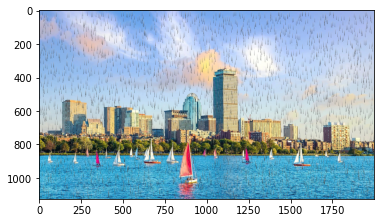

In [393]:
def draw_line(img, r0, c0, r1, c1):
    """Generate anti-aliased line pixel coordinates.
    Parameters
    ----------
    r0, c0 : int
        Starting position (row, column).
    r1, c1 : int
        End position (row, column).
    Returns
    -------
    rr, cc, val : (N,) ndarray (int, int, float)
        Indices of pixels (`rr`, `cc`) and intensity values (`val`).
        ``img[rr, cc] = val``.
    References
    ----------
    .. [1] A Rasterizing Algorithm for Drawing Curves, A. Zingl, 2012
           http://members.chello.at/easyfilter/Bresenham.pdf
    """
    rr = []
    cc = []
    val = []

    dc = abs(c0 - c1)

    dr = abs(r0 - r1)
    err = dc - dr

    if c0 < c1:
        sign_c = 1
    else:
        sign_c = -1

    if r0 < r1:
        sign_r = 1
    else:
        sign_r = -1

    if dc + dr == 0:
        ed = 1
    else:
        ed = math.sqrt(dc*dc + dr*dr)

    c, r = c0, r0
    while True:
        cc.append(c)
        rr.append(r + sign_r)
        val.append(math.fabs(err - dc + dr) / ed)

        err_prime = err
        c_prime = c

        if (2 * err_prime) >= -dc:
            if c == c1:
                break
            if (err_prime + dr) < ed:
                cc.append(c)
                rr.append(r + sign_r)
                val.append(math.fabs(err_prime + dr) / ed)
            err -= dr
            c += sign_c

        if 2 * err_prime <= dr:
            if r == r1:
                break
            if (dc - err_prime) < ed:
                cc.append(c_prime + sign_c)
                rr.append(r)
                val.append(math.fabs(dc - err_prime) / ed)
            err += dc
            r += sign_r
            
    rr = cp.array(rr, dtype=np.int16)
    cc = cp.array(cc, dtype=np.int16)
    val = 1. - cp.array(val, dtype=np.float16)
    
    img[cc, rr, 0] = val * 200
    img[cc, rr, 1] = val * 200
    img[cc, rr, 2] = val * 200
    
    return img

def blur_img(img, k):
    k = 7
    kernel = cp.ones((k,k))/(k*k)
    img1 = cpx.scipy.ndimage.convolve(cp.array(img[:,:,0]), kernel)
    img2 = cpx.scipy.ndimage.convolve(cp.array(img[:,:,1]), kernel)
    img3 = cpx.scipy.ndimage.convolve(cp.array(img[:,:,2]), kernel)
    return cp.stack((img1,img2,img3), axis = 2)

def generate_random_lines(imshape,slant,drop_length,rain_type):
    drops=[]
    area=imshape[0]*imshape[1]
    no_of_drops=area//600

    if rain_type.lower()=='drizzle':
        no_of_drops=area//770
        drop_length=10
    elif rain_type.lower()=='heavy':
        drop_length=30
    elif rain_type.lower()=='torrential':
        no_of_drops=area//500
        drop_length=60

    for i in range(no_of_drops): ## If You want heavy rain, try increasing this
        if slant<0:
            x = cp.random.randint(slant,imshape[1])
        else:
            x = cp.random.randint(0,imshape[1]-slant)
        y = cp.random.randint(0,imshape[0]-drop_length)
        drops.append((x, y))
    return drops, drop_length

def rain_process(image,slant,drop_length,drop_color,rain_drops):
    image = cp.array(image)
    imshape = image.shape  
    image_t = image.copy()
    for rain_drop in rain_drops:
        image_t = draw_line(image_t, int(rain_drop[0]), int(rain_drop[1]), 
                            int(rain_drop[0]+slant),int(rain_drop[1]+drop_length))
    
    #image = blur_img(image_t, 7)
    
    #brightness_coefficient = 0.7 ## rainy days are usually shady 
    #image_HSL = rgb2hsl(image) ## Conversion to HLS
    #image_HSL[:,:,2] = image_HSL[:,:,2]*brightness_coefficient ## scale pixel values down for channel 1(Lightness)
    #image_RGB = hsl2rgb(image_HSL) ## Conversion to RGB
    return image_t

##rain_type='drizzle','heavy','torrential'
def add_rain(image,slant=-1,drop_length=20,drop_color=(200,200,200),rain_type='None'): ## (200,200,200) a shade of gray
    slant_extreme=slant
    imshape = image.shape
    if slant_extreme==-1:
        slant = cp.random.randint(-10,10) ##generate random slant if no slant value is given
    rain_drops, drop_length = generate_random_lines(imshape,slant,drop_length,rain_type)
    return rain_process(image,slant_extreme,drop_length,drop_color,rain_drops)


image_dir = './images'

img = cv2.cvtColor(cv2.imread(image_dir + '/2.png'),cv2.COLOR_BGR2RGB)
out = np.uint8(cp.asnumpy(add_rain(img, rain_type = 'heavy')))

plt.imshow(out)

[  1   2   1   2   1   2   3   2   3   2   3   4   3   4   3   4   5   4
   5   4   5   6   5   6   5   6   7   6   7   6   7   8   7   8   7   8
   9   8   9   8   9  10   9  10   9  10  11  10  11  10  11  12  11  12
  11  12  13  12  13  12  13  14  13  14  13  14  15  14  15  14  15  16
  15  16  15  16  17  16  17  16  17  18  17  18  17  18  19  18  19  18
  19  20  19  20  19  20  21  20  21  20  21  22  21  22  21  22  23  22
  23  22  23  24  23  24  23  24  25  24  25  24  25  25  26  25  26  26
  27  26  27  27  28  27  28  28  29  28  29  29  30  29  30  30  31  30
  31  31  32  31  32  32  33  32  33  33  34  33  34  34  35  34  35  35
  36  35  36  36  37  36  37  37  38  37  38  38  39  38  39  39  40  39
  40  40  41  40  41  41  42  41  42  42  43  42  43  43  44  43  44  44
  45  44  45  45  46  45  46  46  47  46  47  47  48  47  48  48  49  48
  49  49  50  49  50  50  51  50  51  51  52  51  52  52  53  52  53  53
  54  53  54  54  55  54  55  55  56  55  56  56  5

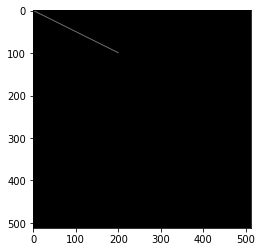

In [370]:
img = np.zeros((512,512,3), dtype = np.uint8)
rr, cc, val = line_aa(1, 1, 100, 200)
img[rr, cc, 0] = val * 255
img[rr, cc, 1] = val * 255
img[rr, cc, 2] = val * 255
print(rr, cc, val)

plt.imshow(img)

In [ ]:
def fog_cupy(x, severity=1):
    c = [(1.5, 2), (2., 2), (2.5, 1.7), (2.5, 1.5), (3., 1.4)][severity - 1]

    shape = cp.array(x).shape
    max_side = max(shape)
    map_size = next_power_of_2(int(max_side))

    x = cp.array(x) / 255.
    max_val = x.max()

    x_shape = cp.array(x).shape
    if len(x_shape) < 3 or x_shape[2] < 3:
        x += c[0] * plasma_fractal_cupy(mapsize=map_size, wibbledecay=c[1])[
                    :shape[0], :shape[1]]
    else:
        print(plasma_fractal_cupy(mapsize=map_size, wibbledecay=c[1])[:shape[0],
             :shape[1]].shape)
        x += c[0] * \
             plasma_fractal_cupy(mapsize=map_size, wibbledecay=c[1])[:shape[0],
             :shape[1]][..., cp.newaxis]
    return cp.clip(x * max_val / (max_val + c[0]), 0, 1) * 255

def frost_cupy(x, severity=1):
    c = [(1, 0.4),
         (0.8, 0.6),
         (0.7, 0.7),
         (0.65, 0.7),
         (0.6, 0.75)][severity - 1]

    idx = np.random.randint(5)
    filename = [resource_filename(__name__, './frost/frost1.png'),
                resource_filename(__name__, './frost/frost2.png'),
                resource_filename(__name__, './frost/frost3.png'),
                resource_filename(__name__, './frost/frost4.jpg'),
                resource_filename(__name__, './frost/frost5.jpg'),
                resource_filename(__name__, './frost/frost6.jpg')][idx]
    frost = cv2.imread(filename)
    print(frost)
    frost_shape = frost.shape
    x_shape = cp.array(x).shape

    # resize the frost image so it fits to the image dimensions
    scaling_factor = 1
    if frost_shape[0] >= x_shape[0] and frost_shape[1] >= x_shape[1]:
        scaling_factor = 1
    elif frost_shape[0] < x_shape[0] and frost_shape[1] >= x_shape[1]:
        scaling_factor = x_shape[0] / frost_shape[0]
    elif frost_shape[0] >= x_shape[0] and frost_shape[1] < x_shape[1]:
        scaling_factor = x_shape[1] / frost_shape[1]
    elif frost_shape[0] < x_shape[0] and frost_shape[1] < x_shape[
        1]:  # If both dims are too small, pick the bigger scaling factor
        scaling_factor_0 = x_shape[0] / frost_shape[0]
        scaling_factor_1 = x_shape[1] / frost_shape[1]
        scaling_factor = cp.maximum(scaling_factor_0, scaling_factor_1)

    scaling_factor *= 1.1
    new_shape = (int(cp.ceil(frost_shape[1] * scaling_factor)),
                 int(cp.ceil(frost_shape[0] * scaling_factor)))
    frost_rescaled = cp.array(cv2.resize(frost, dsize=new_shape,
                                interpolation=cv2.INTER_CUBIC))
    print(frost_rescaled)

    # randomly crop
    x_start, y_start = np.random.randint(0, frost_rescaled.shape[0] - x_shape[
        0]), np.random.randint(0, frost_rescaled.shape[1] - x_shape[1])

    if len(x_shape) < 3 or x_shape[2] < 3:
        frost_rescaled = frost_rescaled[x_start:x_start + x_shape[0],
                         y_start:y_start + x_shape[1]]
        frost_rescaled = rgb2gray_cupy(frost_rescaled)
    else:
        frost_rescaled = frost_rescaled[x_start:x_start + x_shape[0],
                         y_start:y_start + x_shape[1]][..., [2, 1, 0]]
        
    return np.clip(c[0] * cp.array(x) + c[1] * frost_rescaled, 0, 255)

def snow_cupy(x, severity=1):
    #1 и 2  - параметры гауссвого распред.
    #3 - размер
    #4 - threshold
    #5 и 6 - параметры размытия
    #7 - серость?
    c = [(0.01, 0.3, 6, 0.6, 10, 4, 0.8),
         (0.05, 0.3, 6, 0.6, 10, 4, 0.8),
         (0.12, 0.3, 6, 0.6, 10, 4, 0.8)][severity - 1]
#     c = [(0.1, 0.3, 3, 0.5, 10, 4, 0.8),
#          (0.2, 0.3, 2, 0.5, 12, 4, 0.7),
#          (0.55, 0.3, 4, 0.9, 12, 8, 0.7),
#          (0.55, 0.3, 4.5, 0.85, 12, 8, 0.65),
#          (0.55, 0.3, 2.5, 0.85, 12, 12, 0.55)][severity - 1]
#     print(c)
    
    x = cp.array(x, dtype=np.float32) / 255.
    snow_layer = cp.random.normal(size=x.shape[:2], loc=c[0],
                                  scale=c[1])

    snow_layer = clipped_zoom_cupy(snow_layer[..., np.newaxis], c[2])
    snow_layer[snow_layer < c[3]] = 0

    snow_layer = cp.clip(snow_layer.squeeze(), 0, 1)


    snow_layer = _motion_blur_cupy(snow_layer, radius=c[4], sigma=c[5], angle=np.random.uniform(-135, -45))

    # The snow layer is rounded and cropped to the img dims
    snow_layer = cp.round_(snow_layer * 255).astype(cp.uint8) / 255.
    snow_layer = snow_layer[..., cp.newaxis]
    snow_layer = snow_layer[:x.shape[0], :x.shape[1], :]
    
    if len(x.shape) < 3 or x.shape[2] < 3:
        x = c[6] * x + (1 - c[6]) * cp.maximum(x, x.reshape(x.shape[0],
                                                    x.shape[1]) * 1.5 + 0.5)
        snow_layer = snow_layer.squeeze(-1)
    else:
        x = c[6] * x + (1 - c[6]) * np.maximum(x, rgb2gray_cupy(x).reshape(
            x.shape[0], x.shape[1], 1) * 1.5 + 0.5)
    try:
        return cp.clip(x + snow_layer + np.rot90(snow_layer, k=2), 0, 1) * 255
    except ValueError:
        print('ValueError for Snow, Exception handling')
        x[:snow_layer.shape[0], :snow_layer.shape[1]] += snow_layer + np.rot90(
            snow_layer, k=2)
        return cp.clip(x, 0, 1) * 255
    
def zoom_blur_cupy(x, severity=1):
    c = [np.arange(1, 1.11, 0.01),
         np.arange(1, 1.16, 0.01),
         np.arange(1, 1.21, 0.02),
         np.arange(1, 1.26, 0.02),
         np.arange(1, 1.31, 0.03)][severity - 1]

    x = (cp.array(x) / 255.).astype(np.float32)
    out = cp.zeros_like(x)

    set_exception = False
    for zoom_factor in c:
        if len(x.shape) < 3 or x.shape[2] < 3:
            x_channels = cp.array([x, x, x]).transpose((1, 2, 0))
            zoom_layer = clipped_zoom_cupy(x_channels, zoom_factor)
            zoom_layer = zoom_layer[:x.shape[0], :x.shape[1], 0]
        else:
            zoom_layer = clipped_zoom_cupy(x, zoom_factor)
            zoom_layer = zoom_layer[:x.shape[0], :x.shape[1], :]

        try:
            out += zoom_layer
        except ValueError:
            set_exception = True
            out[:zoom_layer.shape[0], :zoom_layer.shape[1]] += zoom_layer

    if set_exception:
        print('ValueError for zoom blur, Exception handling')
    x = (x + out) / (len(c) + 1)
    return cp.clip(x, 0, 1) * 255

def clouds_cupy(x, severity=1):
    c = [(1, 0.4),
         (0.8, 0.6),
         (0.7, 0.7),
         (0.65, 0.7),
         (0.6, 0.75)][severity - 1]

    idx = np.random.randint(5)
    filename = [resource_filename(__name__, './frost/frost1.png'),
                resource_filename(__name__, './frost/frost2.png'),
                resource_filename(__name__, './frost/frost3.png'),
                resource_filename(__name__, './frost/frost4.jpg'),
                resource_filename(__name__, './frost/frost5.jpg'),
                resource_filename(__name__, './frost/frost6.jpg')][idx]
    frost = cv2.imread(filename)
    print(frost)
    frost_shape = frost.shape
    x_shape = cp.array(x).shape

    # resize the frost image so it fits to the image dimensions
    scaling_factor = 1
    if frost_shape[0] >= x_shape[0] and frost_shape[1] >= x_shape[1]:
        scaling_factor = 1
    elif frost_shape[0] < x_shape[0] and frost_shape[1] >= x_shape[1]:
        scaling_factor = x_shape[0] / frost_shape[0]
    elif frost_shape[0] >= x_shape[0] and frost_shape[1] < x_shape[1]:
        scaling_factor = x_shape[1] / frost_shape[1]
    elif frost_shape[0] < x_shape[0] and frost_shape[1] < x_shape[
        1]:  # If both dims are too small, pick the bigger scaling factor
        scaling_factor_0 = x_shape[0] / frost_shape[0]
        scaling_factor_1 = x_shape[1] / frost_shape[1]
        scaling_factor = cp.maximum(scaling_factor_0, scaling_factor_1)

    scaling_factor *= 1.1
    new_shape = (int(cp.ceil(frost_shape[1] * scaling_factor)),
                 int(cp.ceil(frost_shape[0] * scaling_factor)))
    frost_rescaled = cp.array(cv2.resize(frost, dsize=new_shape,
                                interpolation=cv2.INTER_CUBIC))
    print(frost_rescaled)

    # randomly crop
    x_start, y_start = np.random.randint(0, frost_rescaled.shape[0] - x_shape[
        0]), np.random.randint(0, frost_rescaled.shape[1] - x_shape[1])

    if len(x_shape) < 3 or x_shape[2] < 3:
        frost_rescaled = frost_rescaled[x_start:x_start + x_shape[0],
                         y_start:y_start + x_shape[1]]
        frost_rescaled = rgb2gray_cupy(frost_rescaled)
    else:
        frost_rescaled = frost_rescaled[x_start:x_start + x_shape[0],
                         y_start:y_start + x_shape[1]][..., [2, 1, 0]]
        
    return np.clip(c[0] * cp.array(x) + c[1] * frost_rescaled, 0, 255)

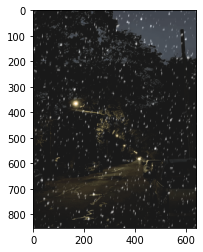

In [181]:
image_dir = './images'

img = cv2.cvtColor(cv2.imread(image_dir + '/1.png'),cv2.COLOR_BGR2RGB)
out = np.uint8(cp.asnumpy(snow_cupy(img ,3)))

plt.imshow(out)

In [43]:
print(rr)

[  1   2   1   2   3   2   3   4   3   4   5   4   5   6   5   6   7   6
   7   8   7   8   9   8   9  10   9  10  11  10  11  12  11  12  13  12
  13  14  13  14  15  14  15  16  15  16  17  16  17  18  17  18  19  18
  19  20  19  20  21  20  21  22  21  22  23  22  23  24  23  24  25  24
  25  26  25  26  27  26  27  28  27  28  29  28  29  30  29  30  31  30
  31  32  31  32  33  32  33  34  33  34  35  34  35  36  35  36  37  36
  37  38  37  38  39  38  39  40  39  40  41  40  41  42  41  42  43  42
  43  44  43  44  45  44  45  46  45  46  47  46  47  48  47  48  49  48
  49  50  49  50  51  50  51  52  51  52  53  52  53  54  53  54  55  54
  55  56  55  56  57  56  57  58  57  58  59  58  59  60  59  60  61  60
  61  62  61  62  63  62  63  64  63  64  65  64  65  66  65  66  67  66
  67  68  67  68  69  68  69  70  69  70  71  70  71  72  71  72  73  72
  73  74  73  74  75  74  75  76  75  76  77  76  77  78  77  78  79  78
  79  80  79  80  81  80  81  82  81  82  83  82  8

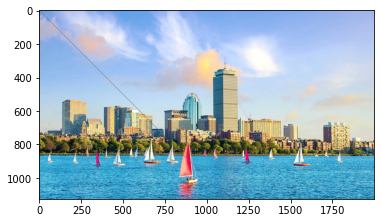

In [47]:
image_dir = './images'

img = cp.array(cv2.cvtColor(cv2.imread(image_dir + '/2.png'),cv2.COLOR_BGR2RGB))
img = draw_line(img, 1, 1, 1000, 1000)
img = np.uint8(cp.asnumpy(img))
plt.imshow(img)

(0.1, 0.3, 3, 0.5, 10, 4, 0.8)
[[-0.11794561 -0.29639817 -0.03947087 ...  0.03190146  0.11412176
  -0.39875876]
 [-0.24019759  0.22309032  0.09261856 ... -0.13218026 -0.03917634
   0.80513129]
 [ 0.09438129  0.4087033   0.21230355 ... -0.04385915  0.10673163
   0.05379382]
 ...
 [-0.26752343  0.56511749 -0.14222102 ...  0.02994657  0.19648073
   0.45596964]
 [ 0.16948914  0.44132226  0.0963467  ... -0.01751678  0.01328989
   0.00795387]
 [ 0.6376488   0.16760988  0.36258715 ...  0.01578132  0.41028397
   0.34324831]]


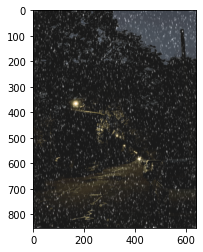

In [100]:
image_dir = './images'

img = cv2.cvtColor(cv2.imread(image_dir + '/1.png'),cv2.COLOR_BGR2RGB)
out = np.uint8(cp.asnumpy(snow_cupy(img ,1)))

plt.imshow(out)

In [11]:
start = time.time()
for i in range(100):
    img = np.zeros((512,512,3), cp.uint8) + 255
    out = np.uint8(cp.asnumpy(zoom_blur_cupy(img ,3)))
    cp.cuda.Stream.null.synchronize()
end = time.time()
print("Time elapsed:", end - start, "sec")

KeyboardInterrupt: 

In [ ]:
aug = Clouds()